## Recommendations in notebook writing

Notebooks are a great tool for data and model exploration. But in that process a lot of Python garbage can get into them as a consequence of the trial and error process.

But once these tasks are done and one arrives to final ideas and insights on the problem under study, the notebook should be **thoroughly cleaned** and the notebook should **concentrate on the insights and conclussions** without, of course, throwing away the good work done.

Below there are a few guidelines about this.

* Put the useful bits of your code as functions on a **Python module** (plus script, if needed) that is imported at the notebook's beginning. 
* Of course that module should be **properly documented** and **formatted** (try to learn about PEP 8 if you are going to write a lot of Python).
* Leave in the notebook **as little code as possible**, ideally one- or two-line cells calling a function, plotting results or so on.
* **Avoid boilerplate code**. If needed, put it in a module.
* Put on the notebook some way to **hide/display the code** (as shown below).
* The displayed information **should be just that, informative**. So forget about large tables, long output cells, dataframe or array displays and so on.
* Emphasize **insights and conclusions**, using as much markdown as needed to clarifiy and explain them.
* Make sure that **number cells consecutively starting at 1.**
* And, of course, make sure that **there are no errors left**. To avoid these last pitfalls, run `Kernel\Restart Kernel and Run All Cells`.

And notice that whoever reads your notebook is likely to toggle off your code and consider just the markdown cells. Because of this, once you feel that your notebook is finished,
* let it rest for one day, 
* then open it up, toggle off the code 
* and read it to check **whether it makes sense to you**.

If this is not the case, **the notebook is NOT finished!!!**

Following these rules you are much more likely to get good grades at school (and possibly also larger bonuses at work).

# Simple Data Analysis and Linear and MLP Regression Modelling

## The `housing` problem

We want to predict median house values in suburbs of Boston.

Accesible en https://archive.ics.uci.edu/ml/datasets/Housing

### Attribute Information:

1. CRIM: per capita crime rate by town 
2. ZN: proportion of residential land zoned for lots over 25,000 sq.ft. 
3. INDUS: proportion of non-retail business acres per town 
4. CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise) 
5. NOX: nitric oxides concentration (parts per 10 million) 
6. RM: average number of rooms per dwelling 
7. AGE: proportion of owner-occupied units built prior to 1940 
8. DIS: weighted distances to five Boston employment centres 
9. RAD: index of accessibility to radial highways 
10. TAX: full-value property-tax rate per \$10,000 
11. PTRATIO: pupil-teacher ratio by town 
12. B: 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town 
13. LSTAT: % lower status of the population 
14. MEDV: Median value of owner-occupied homes in \$1000's

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import time
import pickle
import gzip

import numpy as np
import pandas as pd
import joblib

import matplotlib.pyplot as plt
import seaborn as sns

from sklearnex import patch_sklearn
patch_sklearn()

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold, GridSearchCV

from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.datasets import fetch_openml

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Data Loading

The dataset is preloaded in the sciki-learn library.

In [3]:
boston_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', \
                'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', \
                'MEDV']
source = 'openml'
    
if source == 'uci':
    print("reading from the uci site ...")
    data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data"
    raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
    df_housing_u = raw_df
    df_housing_u.columns = boston_names
    
elif source == 'cmu':
    print("reading from the cmu site ..."
         )
    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
    data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
    target = raw_df.values[1::2, 2]

    df_data = pd.DataFrame(data=data)
    df_target = pd.DataFrame(data=target)
    df_housing_c = pd.concat([df_data, df_target], axis=1)
    df_housing_c.columns = boston_names
    
elif source == 'openml':
    print("loading from openml datasets  ...")
    # Fetch the Boston housing dataset
    boston = fetch_openml(name='boston', version=1, parser='auto')
    df_housing_o = pd.DataFrame(data=boston['data'], columns=boston['feature_names']).astype('float')
    df_housing_o['MEDV'] = boston['target']


loading from openml datasets  ...


In [4]:
df_housing = df_housing_o
joblib.dump(df_housing, 'df_housing.joblib')

vars_housing   = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', \
                      'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'LSTAT']
target_housing = ['MEDV']

## Data Exploration, Visualization and Correlations

Descriptive statistics, boxplots and histograms

### Descriptive analysis

df_housing.describe().round(decimals=2).T

THere are no  missing values and value ranges appear to be reasonable.

## Boxplots, histograms and scatterplots

### Boxplots

We normalize the data so that all boxplots are in a similar scale.

#normalizamos para tener rangos uniformes en histogramas
df_housing_normalizado = (df_housing - df_housing.mean()) / df_housing.std() 

plt.figure( figsize=(8, 5))
sns.set_style("white")
#bx_plot = sns.boxplot(data=df_housing)
bx_plot = sns.boxplot(data=df_housing_normalizado)
#bx_plot = sns.boxplot(data=df_housing)
plt.title("boston_housing boxplots")
plt.xticks(rotation=90)
plt.show()

### Histograms and scatterplots

Histograms and scatter plots against the target of first 7 fatures.

num_vars_to_show = 7 
pair_plot = sns.pairplot( df_housing[ vars_housing[ : num_vars_to_show] + target_housing] )
plt.show()

Histograms and scatter plots against the target of remaining features.

pair_plot = sns.pairplot( df_housing[ vars_housing[ 7: ] + target_housing] )
plt.show()

A few variables seem to have a linear relationship with the target.

### Correlations

df_housing.corr().round(decimals=3)

Una imagen (o un heatmap) vale más que mil palabras

### definir el color map
n_colo##rs = 13
cMap = plt.cm.get_cmap("bwr",lut=n_colors ) 

### definir el heatmap
fig = plt.figure( figsize=(10, 8))
plt.title('housing correlations')
#plt.colorbar(cMap, ticks=[-1, 0, 1])
h_map = sns.heatmap(df_housing.corr().values, 
                    vmin=-1., vmax=1., 
                    cmap=cMap,
                    annot=True,
                    xticklabels=list(df_housing.columns),
      ##              yticklabels=list(df_housing.columns))
plt.xticks(rotation=90) 

### poner ticks en la barra de color
cbar = h_map.collections[0].colorbar
l_tick##s = [k/10. for k in range(-8, 9, 2)]
cbar.set_ticks(l_ticks)

### arreglar cosillas
bottom##, top = h_map.get_ylim()
h_map.set_ylim(bottom + 0.5, top - 0.5)

### generar el dibujo
plt.show()

print( ( df_housing.corr()['MEDV'].abs().round(3).sort_values(ascending=False).T) )

## SV Regressor

We build a first a pipeline model with default values to be hyperparameterized later.

We will work with Gaussian kernels, so we have to set two hyperparameters, `C, gamma` plus the `epsilon` insensitivity. 

In [5]:
x = df_housing[ vars_housing ]
y = df_housing[ target_housing ].values.reshape(-1, )
num_patterns, dim = x.shape

In [6]:
# scaler + svc pipeline
mm_sc = MinMaxScaler()
svr = SVR(kernel='rbf', 
          shrinking=False, 
          tol=1.e-3)

regr = Pipeline(steps=[('minmax_sc', MinMaxScaler()),
                       ('svr', svr)])

y_transformer = StandardScaler()
inner_estimator = TransformedTargetRegressor(regressor=regr,
                                             transformer=y_transformer)

inner_estimator.fit(x, y)

TransformedTargetRegressor(regressor=Pipeline(steps=[('minmax_sc',
                                                      MinMaxScaler()),
                                                     ('svr',
                                                      SVR(shrinking=False))]),
                           transformer=StandardScaler())

In [7]:
svr = inner_estimator.regressor_.named_steps['svr']

print("num_SVs:          ", svr.n_support_)
print("indices_of_svs:   ", svr.support_[ : 10])
print("intercept:        ", svr.intercept_)
print("num SVs_at_bound: ", (abs(svr.dual_coef_) == svr.C).sum())
print("num_SVs:          ", (np.logical_and(abs(svr.dual_coef_) < svr.C, 
                                            abs(svr.dual_coef_) > 0.).sum()))

print("svs:              ", svr.support_vectors_[ : 3, : ])

print("\nsorted_dual_coefs not at bound")
print(np.sort(svr.dual_coef_[ ~(abs(svr.dual_coef_) == svr.C)]))

num_SVs:           [341]
indices_of_svs:    [ 0  1  2  3  4  5  6  7  8 10]
intercept:         [0.58691238]
num SVs_at_bound:  289
num_SVs:           52
svs:               [[0.00000000e+00 1.80000000e-01 6.78152493e-02 0.00000000e+00
  3.14814815e-01 5.77505269e-01 6.41606591e-01 2.69203139e-01
  0.00000000e+00 2.08015267e-01 2.87234043e-01 8.96799117e-02]
 [2.35922539e-04 0.00000000e+00 2.42302053e-01 0.00000000e+00
  1.72839506e-01 5.47997701e-01 7.82698249e-01 3.48961980e-01
  4.34782609e-02 1.04961832e-01 5.53191489e-01 2.04470199e-01]
 [2.35697744e-04 0.00000000e+00 2.42302053e-01 0.00000000e+00
  1.72839506e-01 6.94385898e-01 5.99382080e-01 3.48961980e-01
  4.34782609e-02 1.04961832e-01 5.53191489e-01 6.34657837e-02]]

sorted_dual_coefs not at bound
[-0.95655683 -0.93590643 -0.93586099 -0.92590761 -0.9089956  -0.89696503
 -0.8848893  -0.8701591  -0.86635596 -0.82791208 -0.73306735 -0.68291285
 -0.58231326 -0.54923803 -0.5273537  -0.50762645 -0.47852119 -0.32468361
 -0.2824944  -0

### Can we overfit a SVR?

It's easy: just set a large `C` (i.e., very little regularization), a small `epsilon` (i.e., penalize all errors) and a big `gamma` (i.e., use sharp Gaussians).

We do so and predict over the same train set.

In [8]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

svr = SVR(C=1.e5, 
          kernel='rbf', 
          gamma=1.e3/dim, 
          epsilon=0.,
          shrinking=False, 
          tol=1.e-3)

regr = Pipeline(steps=[('minmax_sc', MinMaxScaler()),
                       ('svr', svr)])

y_transformer = StandardScaler()
inner_estimator = TransformedTargetRegressor(regressor=regr,
                                             transformer=y_transformer)

inner_estimator.fit(x, y)
y_pred = inner_estimator.predict(x)

print("mae: %.4f" % mean_absolute_error(y,y_pred))
print("num_SVs:", inner_estimator.regressor_.named_steps["svr"].n_support_)

mae: 0.0016
num_SVs: [506]


MAE: 0.002


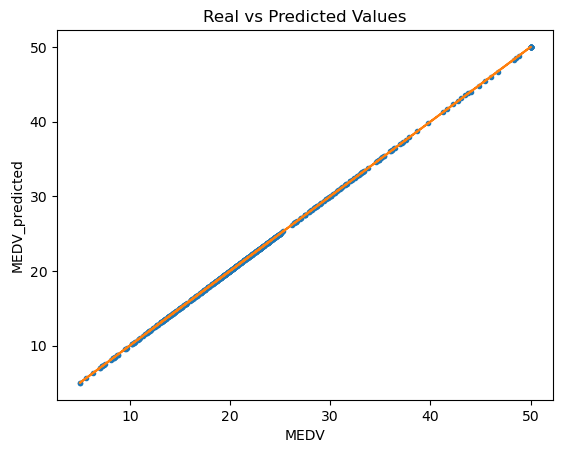

In [9]:
from sklearn.metrics import mean_absolute_error

y_pred = inner_estimator.predict(x)

print("MAE: %.3f" % mean_absolute_error(y, y_pred))

plt.title('Real vs Predicted Values')
plt.xlabel('MEDV')
plt.ylabel('MEDV_predicted')
_ = plt.plot(y, y_pred, '.', y, y, '-')

But if we do a realistic model evaluation ...

In [10]:
n_folds = 5
kf = KFold(n_folds, shuffle=True, random_state=1)

mae_scores = cross_val_score(inner_estimator, x, y, cv=kf, scoring='neg_mean_absolute_error', n_jobs=2)
print("\ncv mae: %.3f" % (-mae_scores.mean()))


cv mae: 4.653


## Hyperparametrization of $C, \gamma, \epsilon$

We do it by grid search CV, but we have to explore **three** hyperparameters, so search times may increase considerably.

We will use 5 folds.

In [11]:
l_C     = [10.**k for k in range(-3, 4)] 
l_gamma = list( np.array([2.**k for k in range(-2, 7)]) / dim)
l_epsilon = [2.**k for k in range(-6, 0)]

param_grid ={'regressor__svr__C': l_C,
             'regressor__svr__gamma': l_gamma,
             'regressor__svr__epsilon': l_epsilon}

print("num_hyperparams", len(l_C) * len(l_gamma) * len(l_epsilon))

mm_sc = MinMaxScaler()
svr = SVR(kernel='rbf', 
          shrinking=False, 
          tol=1.e-3)

regr = Pipeline(steps=[('minmax_sc', MinMaxScaler()),
                       ('svr', svr)])

y_transformer = StandardScaler()
inner_estimator = TransformedTargetRegressor(regressor=regr,
                                             transformer=y_transformer)

cv_estimator = GridSearchCV(inner_estimator, 
                            param_grid=param_grid, 
                            cv=kf, 
                            scoring='neg_mean_absolute_error', 
                            refit=True,
                            n_jobs=-1,
                            return_train_score=True,
                            verbose=1)

t_0 = time.time()
cv_estimator.fit(x, y)
print("grid_search_time: %f segundos" % (time.time() - t_0))

f_cv = "c_gamma_epsilon_cv_search_housing.joblib"
joblib.dump(cv_estimator, f_cv)

num_hyperparams 378
Fitting 5 folds for each of 378 candidates, totalling 1890 fits
grid_search_time: 35.979491 segundos


['c_gamma_epsilon_cv_search_housing.joblib']

## Analyzing GridSearchCV results

We check the adequacy of the best hyperparameters with respect to the grid range.

In [12]:
f_cv = "c_gamma_epsilon_cv_search_housing.joblib"
cv_estimator = joblib.load(f_cv)

In [13]:
print("C_range: %.4f - %.0f" % (np.array(l_C).min(), np.array(l_C).max()))
print("\tbest_C:", cv_estimator.best_params_['regressor__svr__C']) 

print("gamma_range: %.5f - %.5f" % (dim*np.array(l_gamma).min(), dim*np.array(l_gamma).max()))
print("\tbest_gamma:", dim*cv_estimator.best_params_['regressor__svr__gamma'])

print("epsilon_range: %.5f - %.3f" % (np.array(l_epsilon).min(), np.array(l_epsilon).max()))
print("\tbest_epsilon:", cv_estimator.best_params_['regressor__svr__epsilon'])

C_range: 0.0010 - 1000
	best_C: 10.0
gamma_range: 0.25000 - 64.00000
	best_gamma: 16.0
epsilon_range: 0.01562 - 0.500
	best_epsilon: 0.125


We sort hyperparameters by best CV test score

In [14]:
df_C_gamma_epsilon_search = pd.DataFrame.from_dict(cv_estimator.cv_results_)
df_C_gamma_epsilon_search.sort_values(by='mean_test_score', ascending=False)[['param_regressor__svr__C',\
                                                                      'param_regressor__svr__gamma',\
                                                                      'param_regressor__svr__epsilon',\
                                                                      'mean_test_score']][ : 5]

,param_regressor__svr__C,param_regressor__svr__gamma,param_regressor__svr__epsilon,mean_test_score
249,10.0,1.333333,0.125,-2.032167
240,10.0,1.333333,0.0625,-2.036687
231,10.0,1.333333,0.03125,-2.049249
302,100.0,0.666667,0.125,-2.049493
301,100.0,0.333333,0.125,-2.068451


Plotting CV scores against hyperparameters is less clear than for, say, linear regression, as there are many hyperparameter combinations.

We will fix two hyperparameters to their optimal values and then draw the CV scores against the third one.

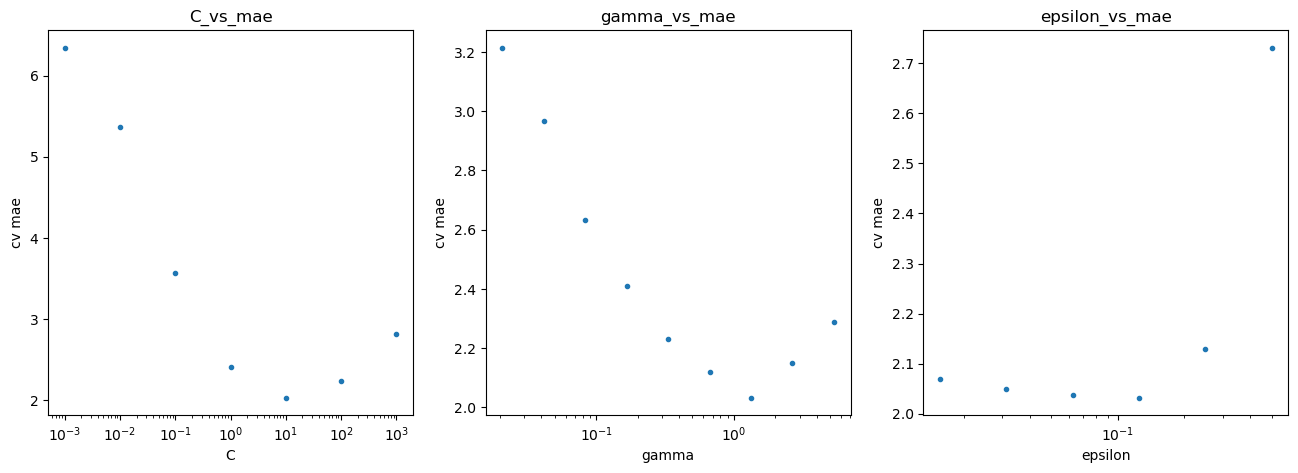

In [15]:
best_C = cv_estimator.best_params_['regressor__svr__C']
best_gamma = cv_estimator.best_params_['regressor__svr__gamma']
best_epsilon = cv_estimator.best_params_['regressor__svr__epsilon']

plt.figure(figsize=(16, 5))
plt.subplot(1, 3, 1)
plt.title('C_vs_mae')
plt.xlabel('C')
plt.ylabel('cv mae')
plt.xscale('log')
idx_best_gamma_eps = np.logical_and(df_C_gamma_epsilon_search['param_regressor__svr__gamma'] == best_gamma, 
                                    df_C_gamma_epsilon_search['param_regressor__svr__epsilon'] == best_epsilon)
_ = plt.plot( df_C_gamma_epsilon_search[idx_best_gamma_eps]['param_regressor__svr__C'], 
             -df_C_gamma_epsilon_search[idx_best_gamma_eps]['mean_test_score'], '.')

plt.subplot(1, 3, 2)
plt.title('gamma_vs_mae')
plt.xlabel('gamma')
plt.ylabel('cv mae')
plt.xscale('log')
idx_best_C_eps = np.logical_and(df_C_gamma_epsilon_search['param_regressor__svr__C'] == best_C, 
                                df_C_gamma_epsilon_search['param_regressor__svr__epsilon'] == best_epsilon)
_ = plt.plot( df_C_gamma_epsilon_search[idx_best_C_eps]['param_regressor__svr__gamma'], 
             -df_C_gamma_epsilon_search[idx_best_C_eps]['mean_test_score'], '.')

plt.subplot(1, 3, 3)
plt.title('epsilon_vs_mae')
plt.xlabel('epsilon')
plt.ylabel('cv mae')
plt.xscale('log')
idx_best_C_gamma = np.logical_and(df_C_gamma_epsilon_search['param_regressor__svr__C'] == best_C, 
                                  df_C_gamma_epsilon_search['param_regressor__svr__gamma'] == best_gamma)
_ = plt.plot( df_C_gamma_epsilon_search[idx_best_C_gamma]['param_regressor__svr__epsilon'], 
             -df_C_gamma_epsilon_search[idx_best_C_gamma]['mean_test_score'], '.')

plt.show()

## Testing the final model

Observe that **the SVR model is essentially unique**

Since we do not have a test set, in order to estimate model performance we introduce randomess in a somewhat artificial way getting CV fold predictions with `cross_val_predict`.

In [16]:
l_preds = []
best_svr = cv_estimator.best_estimator_
kf = KFold(n_folds, shuffle=True, random_state=1)
y_ts_svr = np.clip(cross_val_predict(best_svr, x, y, cv=kf, n_jobs=4), 5., 50.)
print("svr_mae_pred {0:9.6f}  ".format(mean_absolute_error(y, y_ts_svr)))

svr_mae_pred  2.013969  


### Residual histograms and relationship with targets

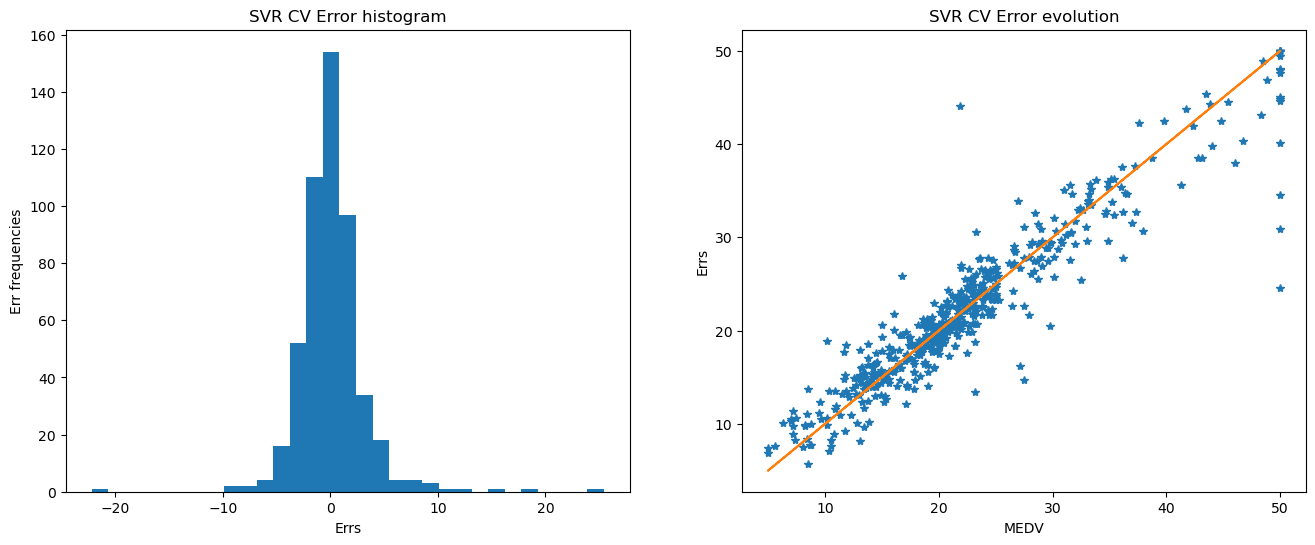

In [17]:
err = y - y_ts_svr

plt.figure( figsize=(16,6))

plt.subplot(1,2,1)
plt.title("SVR CV Error histogram")
plt.xlabel("Errs")
plt.ylabel("Err frequencies")
_ = plt.hist(err, bins=31)

plt.subplot(1,2,2)
plt.title("SVR CV Error evolution")
plt.xlabel("MEDV")
plt.ylabel("Errs")
_ = plt.plot(y, y_ts_svr, '*', y, y, '-')

plt.show()

## Comparing against an MLPR

We load a saved mlp cv_estimator and use it to predict.

But recall that MLPs perform better if used in ensembles.

In [18]:
f_mlp = 'mlp_alpha_search_results.joblib'
mlp_cv_estimator = joblib.load(f_mlp)
best_mlp = mlp_cv_estimator.best_estimator_

f_svr = "c_gamma_epsilon_cv_search_housing.joblib"
svr_cv_estimator = joblib.load(f_svr)
best_svr = svr_cv_estimator.best_estimator_

l_preds_mlp = []
kf = KFold(n_splits=n_folds, shuffle=True, random_state=123)
y_pred_svr =  np.clip(cross_val_predict(best_svr, x, y, cv=kf, n_jobs=-1), 5., 50.)

#the larger the number of MLPs, the more stable should be the mean and median errors
for i in range(20):
    print('training mlp ', i)
    mlp_cv_estimator.best_estimator_.regressor_.named_steps['mlp'].random_state = 200 + i

    y_pred_mlp =  np.clip(cross_val_predict(best_mlp, x, y, cv=kf, n_jobs=-1), 5., 50.)
    l_preds_mlp.append(y_pred_mlp)

a_preds_mlp = np.array(l_preds_mlp).T
mean_y_pred_mlp = a_preds_mlp.mean(axis=1)
median_y_pred_mlp = np.median(a_preds_mlp, axis=1)

print("mae_mean_pred_mlp {0:9.3f}  ".format(mean_absolute_error(y, mean_y_pred_mlp)))
print("mae_median_pred_mlp {0:9.3f}".format(mean_absolute_error(y, median_y_pred_mlp)))

print("mae_mean_pred_svr {0:9.3f}  ".format(mean_absolute_error(y, y_pred_svr)))

training mlp  0
training mlp  1
training mlp  2
training mlp  3
training mlp  4
training mlp  5
training mlp  6
training mlp  7
training mlp  8
training mlp  9
training mlp  10
training mlp  11
training mlp  12
training mlp  13
training mlp  14
training mlp  15
training mlp  16
training mlp  17
training mlp  18
training mlp  19
mae_mean_pred_mlp     2.289  
mae_median_pred_mlp     2.301
mae_mean_pred_svr     2.078  


In [19]:
y_ts_mlp = median_y_pred_mlp
y_ts_svr = y_pred_svr

print("mlp_mae_pred {0:9.6f}  ".format(mean_absolute_error(y, y_ts_mlp)))
print("svr_mae_pred {0:9.6f}  ".format(mean_absolute_error(y, y_ts_svr)))

mlp_mae_pred  2.301454  
svr_mae_pred  2.077784  


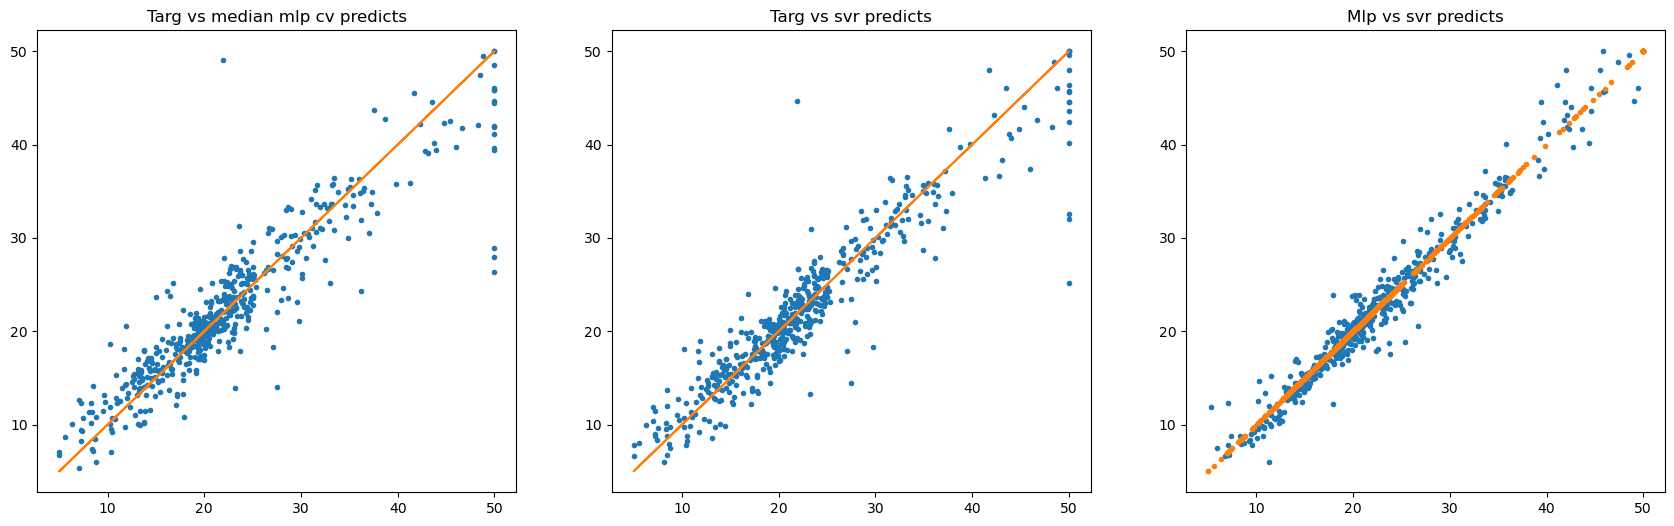

In [20]:
plt.figure(figsize=(21, 6))
plt.subplot(1, 3, 1)
plt.title('Targ vs median mlp cv predicts')
_ = plt.plot(y, y_ts_mlp, '.', y, y, '-')

plt.subplot(1, 3, 2)
plt.title('Targ vs svr predicts')
_ = plt.plot(y, y_ts_svr, '.', y, y, '-')

plt.subplot(1, 3, 3)
plt.title('Mlp vs svr predicts')
_ = plt.plot(y_ts_mlp, y_ts_svr, '.', y, y, '.')